In [43]:
import re
import os
import json
import pdfplumber
from dotenv import load_dotenv

from langchain_upstage import UpstageEmbeddings

In [44]:
load_dotenv('.env', override=True)
UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")

In [20]:
input_path = "./assets/ewha.pdf"
output_path = "./output.pdf" 

In [21]:
# make new .pdf which contains only .txt information

from pypdf import PdfReader, PdfWriter

# PDF 읽기
reader = PdfReader(input_path)
writer = PdfWriter()

# 제외할 페이지 번호 (0-indexed)
exclude_pages = {19, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51}  # 3번째, 6번째, 11번째 페이지 제외

# 원하는 페이지만 추가
for i, page in enumerate(reader.pages):
    if i not in exclude_pages:
        writer.add_page(page)

# 새 PDF 저장
with open("./ewha_text.pdf", "wb") as output_file:
    writer.write(output_file)

In [23]:
# make new .pdf which contains only table information

from pypdf import PdfReader, PdfWriter

reader = PdfReader(input_path)
writer = PdfWriter()

# 남길 페이지 번호 (0-indexed)
keep_pages = [19, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]  # 1번째, 3번째, 6번째, 11번째 페이지만 유지

for page_num in keep_pages:
    if page_num < len(reader.pages):
        writer.add_page(reader.pages[page_num])

with open("./ewha_table.pdf", "wb") as f:
    writer.write(f)

### .txt

1. 장 단위로 쪼갬
2. 수작업으로 각 장 내부의 조 단위로 쪼개어 chapters.txt 파일로 저장
3. 각 장 내부에서 RecursiveTextSplitter(config: max_token=500, overlap=100)으로 쪼개어 ewha_chunk.jsonl 파일로 저장
4. embedding 후 faiss vectorstore에 저장

In [29]:
# .txt만 청킹

def extract_chapters_from_pdf(pdf_path):
    """
    PDF에서 장 단위로 텍스트를 추출하고 파싱
    
    Args:
        pdf_path: PDF 파일 경로
    
    Returns:
        list: [{chapter_num, chapter_title, content}, ...]
    """
    
    full_text = ""
    
    # 1. PDF에서 텍스트 추출
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                # 페이지별 텍스트 추가
                full_text += text + "\n"
    
    # 2. 헤더/푸터 제거 (페이지 번호, 반복되는 헤더 등)
    lines = full_text.split('\n')
    cleaned_lines = []
    
    for line in lines:
        line = line.strip()
        
        # 빈 줄 제거
        if not line:
            continue
            
        # 페이지 번호 패턴 제거 (예: "2-2-1", "1", "- 1 -" 등)
        if re.match(r'^[\d\-\s]+$', line):
            continue
            
        cleaned_lines.append(line)
    
    cleaned_text = '\n'.join(cleaned_lines)
    
    # 3. 장(Chapter) 단위로 분리
    # 패턴: "제N장 [제목]" 또는 "제N조[제목]"
    chapter_pattern = r'제(\d+)장\s+([^\n]+)'
    
    chapters = []
    matches = list(re.finditer(chapter_pattern, cleaned_text))
    
    for i, match in enumerate(matches):
        chapter_num = match.group(1)
        chapter_title = match.group(2).strip()
        
        # 현재 장의 시작 위치
        start_pos = match.end()
        
        # 다음 장의 시작 위치 (마지막 장이면 끝까지)
        if i < len(matches) - 1:
            end_pos = matches[i + 1].start()
        else:
            end_pos = len(cleaned_text)
        
        # 장의 내용 추출
        content = cleaned_text[start_pos:end_pos].strip()
        
        # 추가 정제: 연속된 공백 제거
        content = re.sub(r'\s+', ' ', content)
        content = re.sub(r'\n\s*\n', '\n', content)
        
        chapters.append({
            'chapter_num': chapter_num,
            'chapter_title': chapter_title,
            'content': content
        })
    
    return chapters


def save_chapters_to_txt(chapters, output_path="chapters.txt"):
    """
    추출된 장들을 텍스트 파일로 저장
    """
    with open(output_path, 'w', encoding='utf-8') as f:
        for chapter in chapters:
            f.write(f"제{chapter['chapter_num']}장: {chapter['chapter_title']}\n")
            f.write(f"{chapter['content']}\n\n")
    
    print(f"총 {len(chapters)}개 장이 {output_path}에 저장되었습니다.")


# 사용 예시
if __name__ == "__main__":
    pdf_path = "./ewha_text.pdf"
    
    # 장 단위로 파싱
    chapters = extract_chapters_from_pdf(pdf_path)
    
    # 결과 출력
    for chapter in chapters:
        print(f"\n제{chapter['chapter_num']}장: {chapter['chapter_title']}")
        print(f"내용 길이: {len(chapter['content'])}자")
        print(f"내용 미리보기: {chapter['content'][:100]}...")
    
    # 텍스트 파일로 저장
    save_chapters_to_txt(chapters)
    
    # 리스트로 접근
    print(f"\n총 {len(chapters)}개의 장이 추출되었습니다.")


제1장: 총칙
내용 길이: 206자
내용 미리보기: 제1조(목적) 본교는 대한민국의 교육이념과 기독교정신을 바탕으로 하여 학술의 깊은 이론과 그 광범하고 정밀한 응용방법을 교수․연구하며, 인격을 도야하여 국가와 인류사회의 발전에 공...

제2장: 편제
내용 길이: 1559자
내용 미리보기: 제4조(대학 및 대학원) ① 본교에는 다음 각 호의 대학을 둔다. 1. 인문과학대학, 사회과학대학, 자연과학대학, 엘텍공과대학, 음악대학, 조형예술대학, 사범 대학, 경영대학, 신...

제3장: 부설기관
내용 길이: 136자
내용 미리보기: 제7조 삭제 (2015.2.6.) 제8조(부속 및 연구기관) 본교 부속기관 및 연구기관의 설치 및 운영에 관한 사항은 본교 직 제 규정에 따른다. (개정 2015.2.6.) 제8조...

제4장: 학년, 학기, 수업일수, 휴업일 및 교원의 교수시간 (개정 1998.6.23)
내용 길이: 655자
내용 미리보기: 제10조(학년, 학기) ① 학년은 3월 1일부터 다음해 2월 말일까지로 하고 이를 제1학기와 제2 이화여자대학교 학칙 학기로 나눈다. ② 제1항의 일반학기 외에 하기방학과 동기방학...

제5장: 입학, 편입학 및 등록
내용 길이: 2862자
내용 미리보기: 제13조(입학시기) 입학시기는 학년개시일로부터 30일 이내로 한다. 다만, 재입학, 편입학 및 외국인(외국국적을 보유한 자로서 부모가 모두 외국인인 자)의 신입학 시기는 학기개시일...

제6장: 수업연한 및 재학연한 (개정 2014.11.21)
내용 길이: 843자
내용 미리보기: 제23조(수업연한) ① 각 대학의 수업연한은 4년으로 한다. 다만, 엘텍공과대학의 건축학전공 은 5년으로 하고, 의과대학은 6년으로 하되 의예과는 2년, 의학과는 4년으로 하며, ...

제7장: 교내전학
내용 길이: 227자
내용 미리보기: 제25조(전과) ① 학생이 소속 학부 또는 학과의 변경(이하 “전과”라 한다)을 원할 때에는 「고 등교육법 시행령」 제29조제3항의 규정이 정하는 범위

In [ ]:

# ---------------------------
# 1) 장 기준 분리 함수
# ---------------------------
def split_by_chapter(text):
    pattern = r"(제\d+장[:\s]*[^\n]*)"
    parts = re.split(pattern, text)

    # 첫 부분이 챕터가 아닐 경우 제거
    if not parts[0].startswith("제"):
        parts = parts[1:]

    chapters = []
    for i in range(0, len(parts), 2):
        chapter_title = parts[i].strip()
        chapter_body = parts[i+1].strip() if i+1 < len(parts) else ""
        chapters.append((chapter_title, chapter_body))

    return chapters


# ---------------------------
# 2) 청킹 함수
# ---------------------------
def chunk_text(text, max_char=500, overlap=100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + max_char
        chunk = text[start:end]
        chunks.append(chunk)

        start = end - overlap
        if start < 0:
            start = 0
    return chunks


# ---------------------------
# 3) 장별 청킹
# ---------------------------
def chunk_by_chapter(text, max_char=500, overlap=100):
    chapters = split_by_chapter(text)
    result = []

    for title, body in chapters:
        chunks = chunk_text(body, max_char, overlap)
        for idx, chunk in enumerate(chunks):
            result.append({
                "chapter": title,
                "chunk_id": idx,
                "text": chunk
            })

    return result


# ---------------------------
# 4) 실제 실행 + JSONL 저장
# ---------------------------

input_path = "./chapters.txt"       
output_path = "./ewha_chunk.jsonl"

# txt 파일 읽기
with open(input_path, "r", encoding="utf-8") as f:
    text = f.read()

# 청킹
chunks = chunk_by_chapter(text, max_char=500, overlap=100)

# JSONL 저장
with open(output_path, "w", encoding="utf-8") as f:
    for item in chunks:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"저장 완료! → {output_path}")


저장 완료! → ./ewha_chunk.jsonl


### table

In [46]:
# 입력 및 출력 파일 경로
input_file = './ewha_tables.jsonl'
output_file = './ewha_tables_converted.jsonl'

# chunk_id 시작 번호
chunk_id = 46

# 파일 읽기 및 변환
with open(input_file, 'r', encoding='utf-8') as f_in, \
     open(output_file, 'w', encoding='utf-8') as f_out:
    
    for line in f_in:
        # 각 줄을 JSON으로 파싱
        data = json.loads(line.strip())
        
        # table_type, college, content 결합
        table_type = data.get('table_type', '')
        college = data.get('college', '')
        content = data.get('content', '')
        
        # text 생성 (college가 없는 경우 고려)
        if college:
            text = f"{table_type} {college} {content}"
        else:
            text = f"{table_type} {content}"
        
        # 새로운 구조로 변환
        new_data = {
            'text': text,
            'metadata': {
                'chunk_id': chunk_id
            }
        }
        
        # JSONL 형식으로 저장
        f_out.write(json.dumps(new_data, ensure_ascii=False) + '\n')
        
        # chunk_id 증가
        chunk_id += 1

print(f"변환 완료! 총 {chunk_id - 46}개의 레코드가 변환되었습니다.")
print(f"출력 파일: {output_file}")
        

변환 완료! 총 97개의 레코드가 변환되었습니다.
출력 파일: ./ewha_tables_converted.jsonl


In [ ]:
import json
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS

jsonl_path = "./ewha_chunk.jsonl"            
faiss_save_dir = "./faiss/faiss_ewha"              

# ---------------------------
# 1) JSONL → Document 리스트 변환
# ---------------------------

docs = []

# JSONL 파일 경로 리스트
jsonl_files = [
    "./ewha_chunk_text.jsonl",
    "./ewha_chunk_table.jsonl"
]

# 각 파일을 순회하며 Document 생성
for jsonl_path in jsonl_files:
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line)
            text = item["text"]
            
            # metadata 구조가 다를 수 있으므로 유연하게 처리
            metadata = {}
            
            # chunk_id 추가
            if "chunk_id" in item:
                metadata["chunk_id"] = item["chunk_id"]
            elif "metadata" in item and "chunk_id" in item["metadata"]:
                metadata["chunk_id"] = item["metadata"]["chunk_id"]
            
            docs.append(Document(page_content=text, metadata=metadata))

print(f"총 Document 개수: {len(docs)}")


총 Document 개수: 199


In [52]:
upstage_embedding_model =  UpstageEmbeddings(
                            model="solar-embedding-1-large-passage",
                            api_key=UPSTAGE_API_KEY)

In [53]:
# ---------------------------
# 2) FAISS vectorstore 생성
# ---------------------------
docs = sorted(docs, key=lambda x: x.page_content) # 코드 추가
db = FAISS.from_documents(docs, upstage_embedding_model)

# ---------------------------
# 3) 저장
# ---------------------------
db.save_local(faiss_save_dir)

print(f"FAISS 저장 완료 → {faiss_save_dir}")

FAISS 저장 완료 → ./faiss/faiss_ewha


In [ ]:
# 표 정보 처리

In [26]:
pdf = pdfplumber.open("./ewha_text.pdf")

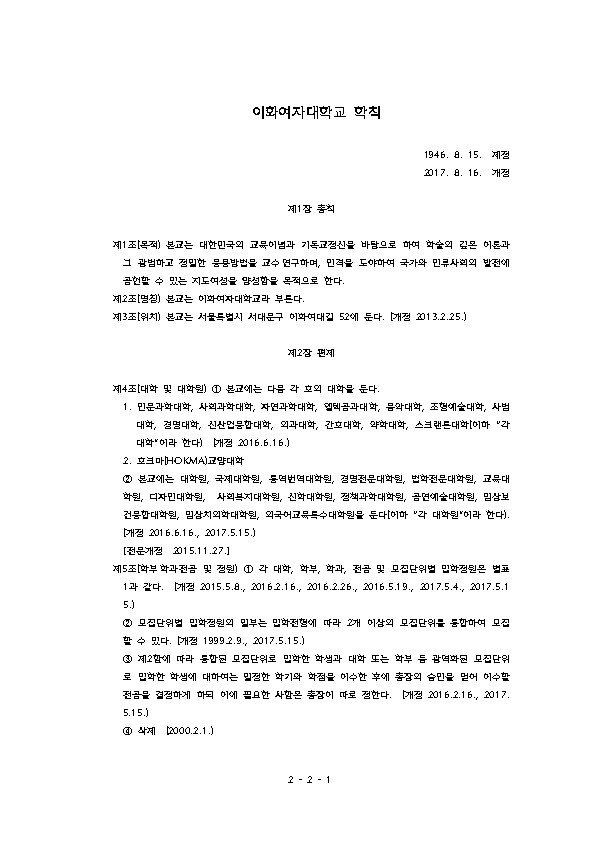

In [27]:
p0 = pdf.pages[0]
im=p0.to_image()
im